In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

In [5]:
torch.cuda.set_device(7)

In [51]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)
gnorm_types = (nn.GroupNorm,)
insnorm_types = (nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)
norm_types = bn_types + gnorm_types + insnorm_types

def cond_init(m:nn.Module, init_func:LayerFunc):
    "Initialize the non-batchnorm layers of `m` with `init_func`."
    if (not isinstance(m, norm_types)) and (not isinstance(m, nn.PReLU)) and requires_grad(m): 
        init_default(m, init_func)

In [5]:
data_name = 'atlas_brain_mr'
bs=1
model_name='baseline11'

In [6]:
# data
f = data_dict[data_name]
train_paths, valid_paths, test1_paths, test2_paths = f()

train_ds = MRI_3D_Dataset(*train_paths)
valid_ds = MRI_3D_Dataset(*valid_paths)
test1_ds = MRI_3D_Dataset(*test1_paths) if test1_paths else None
test2_ds = MRI_3D_Dataset(*test2_paths) if test2_paths else None

data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)
test1_dl = DeviceDataLoader(DataLoader(test1_ds), device=data.device) if test1_ds else None
test2_dl = DeviceDataLoader(DataLoader(test2_ds), device=data.device) if test2_ds else None

# model
f = experiment_model_dict[model_name]; m = f()
apply_leaf(m, partial(cond_init, init_func= nn.init.kaiming_normal_))


In [7]:
MODEL_NAME='dummy'
model_dir='atlas_brain_mr_models'
early_stop=False
loss_func='bce'
epochs=20
lr=0.01
one_cycle=False

In [39]:
# learn
early_stop_cb = partial(EarlyStoppingCallback, monitor='dice_score', mode='max', patience=5)
save_model_cb = partial(SaveModelCallback, monitor='dice_score', mode='max', every='improvement', 
                        name=f'best_of_{MODEL_NAME}')
reduce_lr_cb = partial(ReduceLROnPlateauCallback, monitor='dice_score', mode='max', patience=0, factor=0.8)
csv_logger_cb = partial(CSVLogger, filename=f'logs/{model_dir}/{MODEL_NAME}')

if early_stop: 
    callback_fns = [early_stop_cb, save_model_cb, reduce_lr_cb, csv_logger_cb, ActivationStats]
else: 
    callback_fns = [save_model_cb, csv_logger_cb, ActivationStats]
callbacks = [TerminateOnNaNCallback()]    

learn = Learner(data=data, model=m, opt_func=partial(optim.Adam, betas=(0.9,0.99), eps=1e-4),
                callbacks=callbacks, callback_fns=callback_fns, model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':MixedLoss(10., 2.)}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16()

# schedule
b_its = len(data.train_dl)
ph1 = (TrainingPhase(epochs*0.5*b_its)
        .schedule_hp('lr', (lr/20,lr), anneal=annealing_cos)
        .schedule_hp('eps', (1e-4,1e-4), anneal=annealing_no) # for NAN
        )
ph2 = (TrainingPhase(epochs*0.5*b_its)
        .schedule_hp('lr', (lr,lr/1e5), anneal=annealing_cos)
        .schedule_hp('eps', (1e-4,1e-4), anneal=annealing_no)
        )
gs = GeneralScheduler(learn, (ph1,ph2))

In [40]:
xs = []
for i in np.linspace(0,1,100): 
    xs.append(annealing_no(1e-4, 1e-8, i))

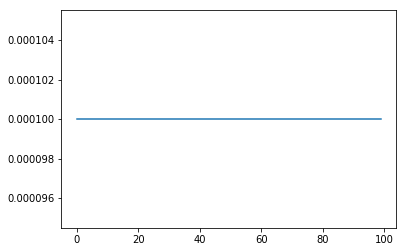

In [41]:
plt.plot(xs)

In [42]:
if one_cycle:
    learn.fit_one_cycle(epochs, max_lr=lr)
else:
    learn.fit(epochs, lr, callbacks=gs)

epoch,train_loss,valid_loss,dice_score,time


KeyboardInterrupt: 

In [29]:
for parameters in learn.mixed_precision.master_params:
    break

In [31]:
norm_type=2
total_norm = 0
for p in parameters:
    param_norm = p.grad.data.norm(norm_type)
    total_norm += param_norm.item() ** norm_type
total_norm = total_norm ** (1. / norm_type)

total_norm

In [36]:
max_norm=.25

In [37]:
clip_coef = max_norm / (total_norm + 1e-6)
if clip_coef < 1:
    for p in parameters:
        p.grad.data.mul_(clip_coef)

In [38]:
norm_type=2
total_norm = 0
for p in parameters:
    param_norm = p.grad.data.norm(norm_type)
    total_norm += param_norm.item() ** norm_type
total_norm = total_norm ** (1. / norm_type)

total_norm

0.24999928934041302

In [12]:
learn.opt

OptimWrapper over Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 0.0001
    lr: 0.0005064309880274034
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 0.0001
    lr: 0.0005064309880274034
    weight_decay: 0
).
True weight decay: True

In [13]:
xb,yb = learn.data.one_batch()

In [14]:
xb.shape, yb.shape

(torch.Size([1, 1, 128, 256, 256]), torch.Size([1, 128, 256, 256]))

In [15]:
xb.dtype

torch.float16

In [16]:
out = learn.activation_stats.modules[0](xb.half().cuda())

In [17]:
out.float().sum()

tensor(-14748290., device='cuda:7', grad_fn=<SumBackward0>)

In [18]:
out.sum()

tensor(-inf, device='cuda:7', dtype=torch.float16, grad_fn=<SumBackward0>)

In [19]:
out.numel()

100663296

In [21]:
learn.activation_stats.stats[0]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [-0., 0., -0.,  ..., -0., -0., -0.],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [-0., 0., -0.,  ..., -0., 0., -0.],
        [0., -0., -0.,  ..., nan, nan, nan]])

In [30]:
learn.activation_stats.modules[0].bias

Parameter containing:
tensor([-0.0104,  0.0020,  0.0079,  0.0029,  0.0037, -0.0115,  0.0043,  0.0133,
        -0.0073, -0.0059,  0.0063, -0.0150], device='cuda:0',
       dtype=torch.float16, requires_grad=True)

In [23]:
learn.activation_stats.stats[0,0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan])

In [24]:
learn.validate()

[0.21341668, tensor(0.9287)]

In [13]:
def stats(t): return (t.mean(), t.std())

In [19]:
params = learn.model.named_parameters()

for n,p in params:
    print(n)
    print(stats(p))
    print()

down1.down.0.weight
(tensor(-0.0051, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>), tensor(0.2671, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>))

down1.down.0.bias
(tensor(-0.0008, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>), tensor(0.0089, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>))

down1.down.1.weight
(tensor(0.2612, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>))

down1.preact_res.c1.1.weight
(tensor(0.2462, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>), tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>))

down1.preact_res.c1.2.weight
(tensor(0.0027, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>), tensor(0.0790, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>))

down1.preact_res.c1.2.bias
(tensor(-0.0002, device='cuda:0', dtype=torch.float16, grad_fn=<Me

In [32]:
class MyReLU(nn.Module):
    def forward(self, x):
        return F.relu(x) - 0.5

In [81]:
m = nn.Sequential(nn.Conv2d(1,16,3),
                  nn.ReLU(),
                  nn.Conv2d(16,16,3),
                  nn.ReLU(),
                  nn.Conv2d(16,16,3),
                  nn.ReLU(),
                  nn.Conv2d(16,16,3))

In [82]:
x = torch.randn(5,1,16,16)

In [83]:
a = m(x)
stats(a)

(tensor(-0.0185, grad_fn=<MeanBackward1>),
 tensor(0.0805, grad_fn=<StdBackward0>))

In [84]:
apply_leaf(m, partial(cond_init, init_func= nn.init.kaiming_normal_))

In [85]:
a = m(x)
stats(a)

(tensor(-0.0306, grad_fn=<MeanBackward1>),
 tensor(1.2393, grad_fn=<StdBackward0>))